# Previsão de fraude em transações com cartão de crédito

Neste notebook, será abordado o problema fraudes de cartão de crédito. Aqui, focarei mais na parte da análise dos dados e resolução do problema, e no readme do projeto no github publicarei as principais conclusões.

O objetivo aqui vai ser: definir se uma transação é fraudulenta ou não, de modo que o cliente do cartão não perca dinheiro.

Sobre o conjunto de dados, os dados foram pré-processados usando análise de componentes principais (PCA) e também a maioria das colunas foram deixadas sem nome, por motivos de proteção aos dados dos clientes.

O conjunto de dados pode ser encontrado em https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando os dados
df = pd.read_csv('dados\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Visualizando o conjunto de dados, vemos que existem apenas 3 variáveis que não foram anonimizadas: tempo, amount e class. Então será feita uma breve análise sobre essas variáveis. Não irei fazer uma análise exploratória das outras variáveis, pois não tenho a informação do que elas significam, então não traria valor para análise de negócio.

## Variável class

A variável class representa se a transação foi fraudulenta ou não.

In [3]:
# Contando a variável class
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- 0: Transação não fraudulenta
- 1: Transação fraudulenta

Como pode ser visto pela tabela acima, as transações fradulentas representam muito pouco do total do conjunto de dados, apenas 0,17%. Isso mostra que o conjunto de dados está extremamente desbalanceado, será necessário aplicar alguma técnica para balancear essas classes.


## Variavel Time

A variável Time representa o intervalo em segundos, da transação avaliada para a primeira transação do dataset

<AxesSubplot:xlabel='Class', ylabel='Time'>

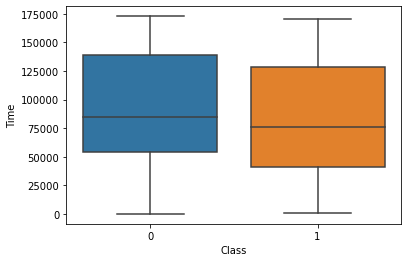

In [4]:
sns.boxplot(x = df['Class'], y = df['Time'])

Podemos ver que esta variável apresenta basicamente o mesmo comportamento para as duas classes, mas creio que esta não seja uma variável importante para o treinamento do modelo.

## Variável Amount

A variável amount representa o valor da transação.

([<matplotlib.axis.XTick at 0x1f4f048edf0>,
 [Text(0, 0, 'Normal'), Text(1, 0, 'Fraude')])

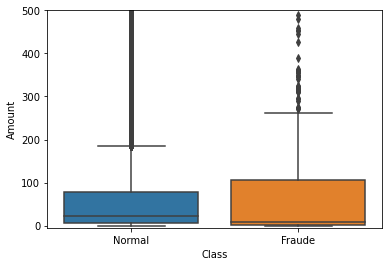

In [5]:
# Criando o boxplot da variável amount
sns.boxplot(x = df['Class'], y = df['Amount'])

# Setando um limite para os valores de transação, devido ao elevado número de outliers.
plt.ylim((-5, 500))
plt.xticks([0, 1], ['Normal', 'Fraude'])

Tive que setar um valor máximo de Y, pois esta variável apresenta muitos outliers. Parece que não há muita distinção dos valores das transações para casos normais ou com fraude.

## Separando os dados de treino e teste

Antes de treinar o modelo, precisamos separar os dados de treino e de validacao, para treinar o modelo e depois fazermos as previsões. Vou separar apenas em dados de treino e validação para poder alimentar o modelo em PyCaret.

In [6]:
from sklearn.model_selection import train_test_split

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e validcao
df_treino, df_validacao = train_test_split(df, test_size = teste_size, random_state = seed)

In [7]:
# Resumo da amostra de dados
print(f'Tamanho dos dados de treino {df_treino.shape}')
print(f'Tamanho dos dados de teste {df_validacao.shape}')

Tamanho dos dados de treino (190820, 31)
Tamanho dos dados de teste (93987, 31)


In [8]:
# Verificando se a amostra está bem distibuida
print(df_treino['Class'].mean())
print(df_validacao['Class'].mean())

0.0017084163085630438
0.0017662017087469544


## Treinamento do modelo usando PyCaret

Para o treinamento do modelo, vamos usar a biblioteca pycaret para treinar vários modelos ao mesmo tempo. Definimos o setup como:
- Dados de treino para treinar o modelo, e dados de validação para treinar o modelo
- Target é a variável Class
- Normalize = True vai aplicar a normalização de variáveis numéricas com z-score,.

Como o conjunto de dados é muito grande, não vou rodar os 18 modelos que são disponibilizados, escolhi alguns modelos que geralmente são os melhores baseados em problemas de classificação, a partir de experiência anteriores com a biblioteca. Os modelos escolhidos foi o ExtraTree e Light Gradient Boosting.

A partir disso, vou pegar o modelo com melhor performance e testar nos dados de validação para analisar a performance do modelo.

In [9]:
# Importando o módulo do caret, que trazer os algoritmos de classificação
from pycaret.classification import *

# Definindo o setup
modelagem = setup(data = df_treino,
                  target = 'Class',
                  test_data = df_validacao,
                  normalize = True)

# Testando o modelo e organizando por 
modelo = compare_models(include = ['gbc', 'et'])


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9995,0.9440,0.7577,0.9484,0.8412,0.8410,0.8469,9.9290
gbc,Gradient Boosting Classifier,0.9989,0.6499,0.4741,0.8019,0.5757,0.5752,0.6045,126.2210


Com os modelos treinados, foram feitas previsões abaixo para avaliar a performance do melhor modelo.

In [10]:
# Fazendo previsoes no modelo
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9996,0.9745,0.8494,0.9338,0.8896,0.8894,0.8904


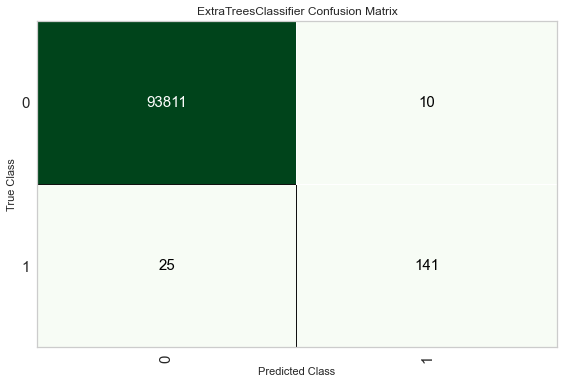

In [65]:
# Confusion Matrix ET
plot_model(modelo, plot = 'confusion_matrix')

O modelo apresentou uma ótima performance, com acurácia próxima de 1. Porém, quando avaliamos a previsão para transações fraudulenta, o modelo acerta 'apenas' 83%. Portanto, vemos que o modelo aprendeu bem sobre a classe não-fraudulenta mas não conseguiu replicar para a outra classe.

Sendo assim, eu vejo uma oportunidade de melhora na performance na entrega da solução. Para isso, vou testar dois modelos muito utilizados para problemas de classificação.

# Criando modelos

Na etapa anterior, desenvolvi um modelo usando a biblioteca PyCaret, que gera modelos automaticamente o que auxilia para executar vários testes. Porém, o resultado em dados de treino usando a métrica f1-score foi de 88% basicamente, porém esse resultado pode ser melhorado. Para isso vou criar 2 modelos, um XGBoost e um RandomForest, que são ótimos modelos para classificação, e normalmente apresentam bons resultados.

A vantagem de criar um modelo não-automatizado é que vou ter mais maleabilidade para trabalhar com os dados do que o PyCaret, então vamos analisar.

Etapas:
- Remover variável Time do modelo
- Normalizar variável amount
- Testar Over e UnderSampling
- Testar os modelos XGBoost e RF

A variável time será removida, esta variável não tem muito sentido para o treinamento do modelo pois não traz nenhuma informação relevante para o negócio, é apenas um contador.

In [12]:
# Removendo a variável Time
df1 = df.iloc[:, 1:31]

# Visualizando os dados
df1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


A primeira etapa foi normalizar a variável amount. Vai ser utilizado a padronização da variável amount, para manter na mesma escala dos dados e facilitar o treinamento do modelo.

A padronização é uma técnica útil para transformar atributos com uma distribuição
gaussiana e diferentes médias e desvios padrão para uma distribuição Gaussiana padrão com
uma média de 0 e um desvio padrão de 1.

In [13]:
# Padronização da variável amout
from sklearn.preprocessing import StandardScaler

# Criando o padronizador
std_scaler = StandardScaler()

# Aplicando o padronizador na variável amount
df1['Amount'] = std_scaler.fit_transform(df1['Amount'].values.reshape(-1, 1))

Uma etapa muito importante é separar os dados de treino e teste. Os dados de treino vão ser usados para treinar / ensinar o modelo e os dados de teste para validar a performance do modelo. Foi usado a função train_test_split para separar os dados de teste, usei uma proporção de 67-33 para os dados de treino e teste.

In [31]:
# Dividindo dados de treino e teste
from sklearn.model_selection import train_test_split

# Separando as variáveis preditoras e target
X = df1.iloc[:, 0:29]
y = df1.iloc[:, 29]

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = teste_size, random_state = seed, stratify = y)

### Balanceando as classes

Como foi mostrado no começo do trabalho, a variável target está extremamente desbalanceada, então é necessária uma ação. Existem duas abordagens que podem ser tomadas: oversampling e undersampling. O oversampling é aumentar o número de observações nos casos da variável com menos observações, e o undersampling é reduzir o número de observações da classe com mais observações.

Abaixo montei as duas abordagens para avaliar qual a melhor abordagem a ser tomada. Usei a biblioteca imblearn que fornece as funções para isso.

In [15]:
# Fazendo UnderSampling dos dados
from imblearn.under_sampling import RandomUnderSampler 

# Criando o balanceador undersampling
rus = RandomUnderSampler(random_state=42)

# Aplicando o balanceador
X_treino_under, Y_treino_under = rus.fit_resample(X_treino, Y_treino)

In [16]:
# Fazendo OverSampling dos dados
from imblearn.over_sampling import SMOTE

# Cria o balanceador SMOTE
smote_bal = SMOTE()

# Aplica o balanceador
X_treino_smote, Y_treino_smote = smote_bal.fit_resample(X_treino, Y_treino)

### Random Forest

Uma floresta aleatória é um metaestimador que ajusta vários classificadores de árvore de decisão em várias subamostras do conjunto de dados e usa a média para melhorar a precisão da previsão e controlar o sobreajuste. 

Segue a documentação abaixo:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

O treinamento será feito usando os dados com oversampling e undersampling. E será gerado um report dos resultados dos modelos de Random Forest e XGBoost, com algumas métricas de classificação. A principal referência para avaliar a performance do modelo será a matriz de confusão, em que mostra os acertos e erros do modelo.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.91      0.82      0.86       162

    accuracy                           1.00     93987
   macro avg       0.96      0.91      0.93     93987
weighted avg       1.00      1.00      1.00     93987



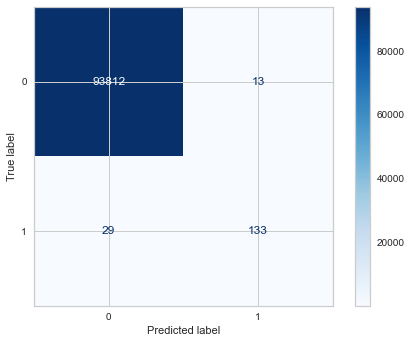

AUC_under: 0.9104

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93825
           1       0.06      0.93      0.11       162

    accuracy                           0.97     93987
   macro avg       0.53      0.95      0.55     93987
weighted avg       1.00      0.97      0.99     93987

AUC_under: 0.9498



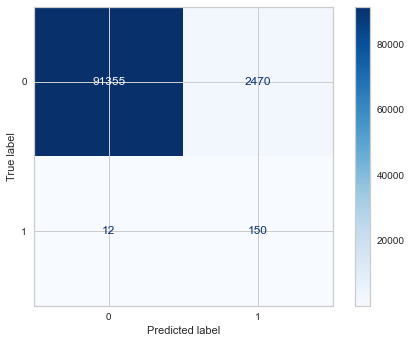

In [17]:
# Import Library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

# Criando o objeto Random Forest smote
RF_smote = RandomForestClassifier()

# Treinando o modelo Random Forest com os dados transformados com smote
RF_smote.fit(X_treino_smote, Y_treino_smote)

# Fazendo as previsões e construindo o relatório
previsoes_smote = RF_smote.predict(X_teste)
report_smote = classification_report(Y_teste, previsoes_smote)

# Imprimindo o relatório
print(report_smote)

# Plotando graficamente a matriz de confusão
plot_confusion_matrix(RF_smote, X_teste, Y_teste,
                                 cmap=plt.cm.Blues)

# Mostrando a matriz de confusão
plt.show()

# imprimir a área sob da curva
print("AUC_under: {:.4f}\n".format(roc_auc_score(Y_teste, previsoes_smote)))

# Criando o objeto Random Forest 
RF_under = RandomForestClassifier()

# Treinando o modelo Random Forest com os dados transformados com undersampling
RF_under.fit(X_treino_under, Y_treino_under)

# Fazendo as previsões e construindo o relatório
previsoes_under = RF_under.predict(X_teste)
report_under = classification_report(Y_teste, previsoes_under)

# Imprimindo o relatório
print(report_under)

# imprimir a área sob da curva
print("AUC_under: {:.4f}\n".format(roc_auc_score(Y_teste, previsoes_under)))

# Plotando graficamente a matriz de confusão
plot_confusion_matrix(RF_under, X_teste, Y_teste,
                                 cmap=plt.cm.Blues)
plt.show()

Como visto acima, o modelo com os dados com oversampling foi praticamente perfeito quando olhamos a métrica F1-Score. Porém, quando olhamos a classe de fraude, o modelo acertou 82%. Enquanto o modelo com undersampling, mesmo com F1-Score menor, acertou 93% das fraudes.

Então, nesse momento é necessário o entendimento do negócio, pois tem um trade-off a ser analisado. Precisa discutir se vale a pena usar um modelo que acerta menos no geral, mas tem maior precisão nos casos com fraude, ou se levo em conta a acurácia geral e uso um modelo com mais acerto de não-fraude e menos acerto com fraude.

O papel do cientista de dados, é gerar o melhor modelo possível para responder uma pergunta de negócio ou resolver o problema em si, então a partir deste ponto eu levaria estes dois modelo e apresentaria os pós e contra aos tomadores de decisão, que optariam pela escolha que faz mais sentido pro negócio.

### XGBoost Classifier

O XGBoost é baseado em árvore de decisão e que utiliza uma estrutura de Gradient boosting.

[12:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.77      0.86      0.81       162

    accuracy                           1.00     93987
   macro avg       0.88      0.93      0.91     93987
weighted avg       1.00      1.00      1.00     93987



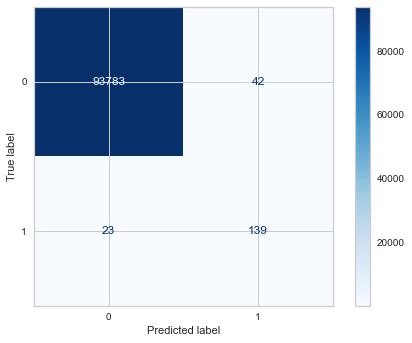

AUC_under: 0.9288

[12:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     93825
           1       0.05      0.94      0.09       162

    accuracy                           0.97     93987
   macro avg       0.52      0.95      0.53     93987
weighted avg       1.00      0.97      0.98     93987

AUC_under: 0.9520



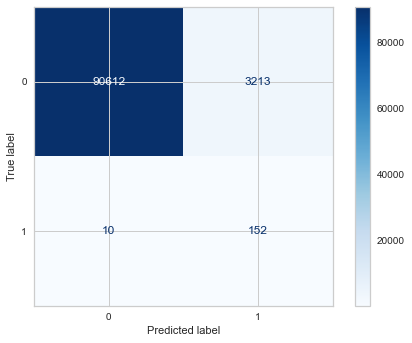

In [32]:
# Import Library
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from xgboost import XGBClassifier
import time

inicio = time.time()

# Criando o modelo
xgb = XGBClassifier()

# Criando o objeto Random Forest smote
xgb_smote = XGBClassifier()

xgb_smote.fit(X_treino_smote, Y_treino_smote)

# Fazendo as previsões e construindo o relatório
previsoes_smote = xgb_smote.predict(X_teste)
report_smote = classification_report(Y_teste, previsoes_smote)

# Imprimindo o relatório
print(report_smote)

# Plotando graficamente a matriz de confusão
plot_confusion_matrix(xgb_smote, X_teste, Y_teste,
                                 cmap=plt.cm.Blues)
plt.show()

# imprimir a área sob da curva
print("AUC_under: {:.4f}\n".format(roc_auc_score(Y_teste, previsoes_smote)))

# Criando o objeto Random Forest 
xgb_under = XGBClassifier()

xgb_under.fit(X_treino_under, Y_treino_under)

# Fazendo as previsões e construindo o relatório
previsoes_under = xgb_under.predict(X_teste)

# Previsoes de probabilidade do modelo
previsoes_proba = xgb_under.predict_proba(X_teste) * 100
report_under = classification_report(Y_teste, previsoes_under)

# Imprimindo o relatório
print(report_under)

# imprimir a área sob da curva
print("AUC_under: {:.4f}\n".format(roc_auc_score(Y_teste, previsoes_under)))

# Plotando graficamente a matriz de confusão
plot_confusion_matrix(xgb_under, X_teste, Y_teste,
                                 cmap=plt.cm.Blues)
plt.show()
fim = time.time()


Analisando os resutlados do XGboost com os dados undersampling, foi onde teve o maior número de acertos de casos com fraude, onde acertou 94%, 1% a mais do que o modelo de Random Forest. Se compararmos com o modelo do Pycaret, que acertou 83% dos casos com fraude foi uma melhora significativa de 10%.

Portanto, vamos definir esse como o melhor modelo, pois obteve a melhor classificação de fraude.

In [33]:
# Tempo de execução do programa do modelo
print(fim - inicio)

269.50069999694824


O modelo levou um pouco mais de 4 minutos para rodar, o que é razoável.

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

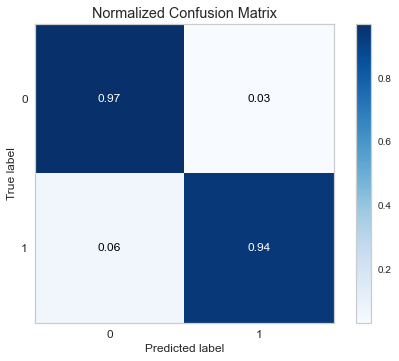

In [34]:
import scikitplot as skplt

# plotar a matrix de confusão com a proporção de acertos
skplt.metrics.plot_confusion_matrix(Y_teste, previsoes_under, normalize=True)

O gráfico acima mostra a porcentagem de acerto do modelo. Podemos ver que para casos em que não ocorreram fraude, o modelo acertou 97% e nos casos com fraude 94%.

Com o modelo escolhido, vamos salvar o modelo em disco para poder ser replicado em análises futuras.

In [36]:
# Finalizando o modelo
xgb_final = finalize_model(xgb_under)

In [37]:
# Salvando o mdelo
save_model(xgb, 'xgb_fraud_card')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                max_delta_step=None, max_depth=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_estimators=100,
                                n_jobs=None, num_parallel_tr

### Entrega do resultado

Para entregar a solução de negócio para o cliente, vamos salvar as previsões de modelo e também a probabilidade de fraude ou não. Com as probabilidades de fraudeo, o gestor pode priorizar as transações com maior probabilidade de serem fraudulentas e intervir com maior precisão.

In [56]:
# Salvando o resultado das previsões com o modelo
resultado = X_teste.copy()
resultado['Class'] = Y_teste
resultado['previsoes'] = previsoes_under
resultado['prob_fraud'] = np.nan
resultado['prob_fraud'] = previsoes_proba

# Loop para criar a coluna com probabilidades
for obs in resultado.index:
        resultado['prob_fraud'][obs] = 100 - resultado['prob_fraud'][obs]

resultado.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,previsoes,prob_fraud
85953,1.245525,-0.015101,0.172603,0.166342,-0.506459,-0.927565,0.047181,-0.113833,0.069392,0.002524,...,-0.063552,0.609737,0.468311,1.062800,-0.101217,-0.016988,-0.345233,0,0,0.224205
223970,-0.934617,-0.555725,0.711681,-2.694034,-0.177240,-0.199004,0.706445,-0.104712,-0.547377,-0.417462,...,-0.048551,-1.024256,0.336081,-0.282926,0.015484,0.059845,0.246484,0,0,0.232971
270786,2.068716,0.110282,-1.674298,0.448383,0.300052,-0.958044,0.136712,-0.201081,0.598710,-0.356298,...,0.362076,0.618413,-0.296532,0.167820,-0.067238,-0.031126,-0.349271,0,0,0.058716
20082,1.069910,0.042439,0.066574,0.463081,-0.126530,-0.569521,0.307067,-0.052327,-0.431864,0.049770,...,0.140737,0.207423,0.125304,0.132862,-0.063693,0.007517,-0.093554,0,0,0.233948
27885,-0.511955,-0.098190,1.950175,-2.994091,-0.772603,-0.901506,-0.031516,0.144551,2.047939,-2.346655,...,-0.271873,0.434856,0.326248,-0.787249,0.105273,0.020716,-0.349231,0,0,4.776283


In [61]:
# Criando o dataframe para entrega do modelo
entrega_final = pd.DataFrame(resultado.iloc[:, 31])
entrega_final = entrega_final.reset_index()
entrega_final.head()

,index,prob_fraud
0,85953,0.224205
1,223970,0.232971
2,270786,0.058716
3,20082,0.233948
4,27885,4.776283


A última etapa é gerar o arquivo csv para entrega para o cliente.

In [63]:
# Salvando o resultado do trabalho em um arquivo csv
entrega_final.to_csv('entrega_final.csv')